In [38]:
from dataclasses import dataclass
import numba

import numpy as np
import matplotlib.pyplot as plt

In [40]:
def Vec(*args):
  """Create numpy vector
  example:
    Vec(1,2,3) --> 3D vector (1,2,3)
  """
  return np.array(args)

def normalize(v: Vec):
  """Normalize a vector
  example:
    normalize(Vec(1,2,2)) --> Vec(1/3, 2/3, 2/3)
  """
  return v / np.linalg.norm(v)

In [41]:
a = Vec(1,2,3)
b = Vec(4,5,6)

a+b

array([5, 7, 9])

In [44]:
@numba.experimental.jitclass
class Ray:
  def __init__(self, pos, dir):
    self.pos = pos
    self.dir = dir
  # pos: Vec
  # dir: Vec

@numba.experimental.jitclass
class Intersection:
  """Ray-object intersection class
  t: Time of the intersection
  pos: Position of the intersection 
    equals to ray.pos + t * ray.dir
  normal: Surface normal of the object at the intersection
  """
  def __init__(self, t, pos, normal):
    self.t = t
    self.pos = pos
    self.normal = normal
  # t: float
  # pos: Vec
  # normal: Vec

In [47]:
class Shape:
  """
  Base class for shape
  """
  def intersect(self, ray: Ray):
    """
    returns (bool intersect, Intersection info)
      - bool intersect: True if the ray intersects with the sphere, False otherwise
      - Intersection info: Intersection class containing information
    """
    raise NotImplementedError()
    return False, Intersection(np.inf, None, None)

@numba.experimental.jitclass
class Sphere:
  """
  Sphere shape
  """
  def __init__(self, center: Vec, radius: float):
    self.center = center
    self.radius = radius

  def intersect(self, ray: Ray):
    """Ray-sphere intersection test
    @TODO: Implement ray-sphere intersection test
    See https://www.scratchapixel.com/lessons/3d-basic-rendering/minimal-ray-tracer-rendering-simple-shapes/ray-sphere-intersection
    You don't need to fill in Intersection.normal yet; leave it None
    
    Useful numpy methods
     - np.dot
     - np.sqrt
    """

    pos_center = ray.pos - self.center
    a = 1
    b = 2 * np.dot(ray.dir, pos_center)
    c = np.dot(pos_center, pos_center) - self.radius * self.radius

    intersect = None
    delta = b**2 - 4*a*c
    if delta > 1e-7:
      x0 = (-b - np.sqrt(delta)) / (2 * a)
      x1 = (-b + np.sqrt(delta)) / (2 * a)
      if x0 >= 0:
        # x0 is closest.
        x = x0
        intersect = Intersection(x, ray.pos + x * ray.dir, None)
      elif x1 >= 0:
        # x0 is negative, x1 is closest
        x = x1
        intersect = Intersection(x, ray.pos + x * ray.dir, None)
    elif abs(delta) < 1e-7:
      x = -b / (2*a)
      if x >= 0:
        intersect = Intersection(x, ray.pos + x * ray.dir, None)
    if intersect is None:
      return False, Intersection(np.inf, None, None)
    else:
      return True, intersect

@numba.experimental.jitclass
class Cube:
  def __init__(self, center: Vec, size: Vec):
    self.center = center
    self.size = size

  def intersect(self, r: Ray):
    """Ray-box intersection test
    @OPTIONAL: Implement ray-box intersection test
    See https://gamedev.stackexchange.com/a/18459
    You don't need to fill in Intersection.normal yet; leave it None

    Useful numpy methods
     - np.maximum / np.minimum
     - np.max / np.min
    """

    df_x = 1.0 / r.dir[0]
    df_y = 1.0 / r.dir[1]
    df_z = 1.0 / r.dir[2]

    lb = self.center - self.size * 0.5
    rt = self.center + self.size * 0.5

    t1 = (lb[0] - r.pos[0]) * df_x
    t2 = (rt[0] - r.pos[0]) * df_x
    t3 = (lb[1] - r.pos[1]) * df_y
    t4 = (rt[1] - r.pos[1]) * df_y
    t5 = (lb[2] - r.pos[2]) * df_z
    t6 = (rt[2] - r.pos[2]) * df_z

    tmin = max(max(min(t1, t2), min(t3, t4)), min(t5, t6))
    tmax = min(min(max(t1, t2), max(t3, t4)), max(t5, t6))

    if tmax < 0: return False, Intersection(np.inf, None, None)
    if tmin > tmax: return False, Intersection(np.inf, None, None)

    t = tmin
    return True, Intersection(t, r.pos + r.dir * t, None)

@numba.experimental.jitclass
class CompositeShape:
  def __init__(self, shapes):
    self.shapes = shapes
  
  def intersect(self, ray: Ray):
    """Ray-composite shape intersection test
    @TODO: Implement ray-composite shape intersection test
    For every shape in self.shapes, return Intersection with the smallest t
    """
    min_t = np.inf
    min_intersect = (False, Intersection(np.inf, None, None),)
    for shape in self.shapes:
      is_hit, intersect = shape.intersect(ray)
      if is_hit and intersect.t <= min_t:
        min_t = intersect.t
        min_intersect = (True, intersect)
    return min_intersect

In [48]:
import tqdm

W = 256
H = 256
img = np.zeros((W, H))
camera_center = Vec(0,0,1)
s1 = Sphere(Vec(0,0,-2), 1)
s2 = Sphere(Vec(1,1,-3), 0.8)
c1 = Cube(Vec(-1,-1,-2), Vec(1, 1, 1))

env = CompositeShape([s1, s2, c1])

for w in tqdm.trange(W, position=0):
  for h in tqdm.trange(H, position=1, leave=False):
    # Compute pixel position from pixel index (w, h)
    pixel_pos = Vec((w + 0.5) / W - 0.5, (h + 0.5) / H - 0.5, 0)

    # Generate a ray originated form camera center to pixel position
    ray = Ray(camera_center, normalize(pixel_pos - camera_center))
    
    # Perform intersection test with environment
    intersect, info = env.intersect(ray)
    img[w,h] += 1 / info.t

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Cannot resolve setattr: (instance.jitclass.Sphere#7fe8dbebed00<>).center = array(int64, 1d, C)

File "../../../../tmp/ipykernel_31372/2977760603.py", line 20:
<source missing, REPL/exec in use?>

During: typing of set attribute 'center' at /tmp/ipykernel_31372/2977760603.py (20)

File "../../../../tmp/ipykernel_31372/2977760603.py", line 20:
<source missing, REPL/exec in use?>

During: resolving callee type: jitclass.Sphere#7fe8dbebed00<>
During: typing of call at <string> (3)

During: resolving callee type: jitclass.Sphere#7fe8dbebed00<>
During: typing of call at <string> (3)


File "<string>", line 3:
<source missing, REPL/exec in use?>


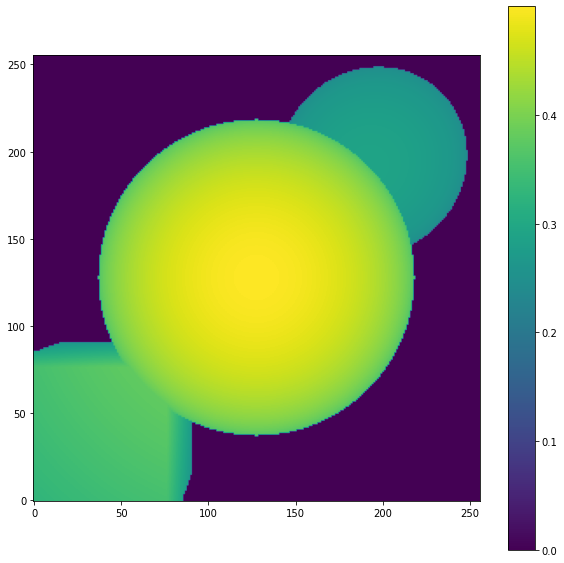

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(img, origin='lower')
plt.colorbar()
plt.show()